<a href="https://colab.research.google.com/github/yourkik/CityScape-synthetic-data-check/blob/main/Aimmo(train).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 준비

In [ ]:
import os
import tarfile
import zipfile

def extract_file(file_path, extract_to=None):
    if extract_to is None:
        extract_to = os.path.splitext(file_path)[0]  # 기본 폴더명 설정

    os.makedirs(extract_to, exist_ok=True)

    if file_path.endswith(('.tar', '.tar.gz', '.tgz', '.tar.bz2', '.tar.xz')):
        with tarfile.open(file_path, 'r:*') as tar:
            tar.extractall(path=extract_to)
            print(f'Extracted {file_path} to {extract_to}')

    elif file_path.endswith('.zip'):
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f'Extracted {file_path} to {extract_to}')

    else:
        print('Unsupported file format')

In [ ]:
# extract_file("/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit_remove.zip")

In [ ]:
# extract_file("/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/gtFine_trainvaltest.zip","/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/gtFine")
# extract_file("/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/leftImg8bit_trainvaltest.zip","/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/leftImg8bit_real")
# extract_file("/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit.tar","/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit_syn")

In [ ]:
import random
# random_name을 가진 json을 만들 때만 사용
def make_random_list(root_syn):
    # custom_data 폴더에서 모든 이미지 경로 수집
    custom_image_names = []

    for city in os.listdir(root_syn):
        city_syn_path = os.path.join(root_syn, city)
        for img_name in os.listdir(city_syn_path):
            if img_name.endswith('_leftImg8bit.png'):
                custom_image_names.append(img_name)
                # print(custom_image_names[0])
                # return 0

    # print("합성 이미지 수: ",len(custom_image_names))
    # syn_size만큼 랜덤하게 이미지 선택
    # 1. 랜덤한 순서로 배열
    random.shuffle(custom_image_names)

    # 2. JSON 파일로 저장
    with open('shuffled_image_names.json', 'w') as f:
        json.dump(custom_image_names, f)

    print("Shuffled image names saved to 'shuffled_image_names.json'.")


    # # 예시: 2개 가져오기
    # n = 2
    # selected_images = get_random_image_names(n)
    # print(f"Selected {n} images: {selected_images}")

---
## CityScape data 바로 적용

---
### 초기 세팅

In [ ]:
# Hyper Parameter
lr=1e-3
epoch = 100
batch_size = 16  # colab 16, 집 4

# 데이터셋 비율 설정 (syn 비율)
syn_ratio = 1.0

# class 수
num_classes = 19

# 데이터셋 경로(원래 drive면 MyDrive/Aimmo/Dataset/)
real_root = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data"
syn_root = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic"
gt_root = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data"  # Real 데이터의 target
random_image_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/shuffled_image_names_remove.json"  # random으로 shuffle한 합성 이미지 이름들

# # 데이터셋 경로로(pc)
# real_root = "D:/Aimmo/CityScape/dataset/real/data"
# syn_root = "D:/Aimmo/CityScape/dataset/syn/leftImg8bit"
# gt_root = "D:/Aimmo/CityScape/dataset/real/data"
# random_image_names = "D:/Aimmo/CityScape/shuffled_image_names.json"

# # dataset 경로(notebook)
# real_root = "C:/Aimmo/Data/20250203_car_segmentation/real"
# syn_root = "C:/Aimmo/Data/20250203_car_segmentation/synthetic"
# gt_root = "C:/Aimmo/Data/20250203_car_segmentation/real"
# random_image_path = "C:/Aimmo/Data/20250203_car_segmentation/synthetic/shuffled_image_names.json"

In [ ]:
# !pip install wandb

In [ ]:
# CityScape dataset 생성을 위한 기본 내용들 모음
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import Cityscapes
import torchvision.models.segmentation as models
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights

from tqdm import tqdm
import datetime

# 🔹 이미지 전처리 변환 정의 (Real과 Synthetic 공통)
transform = transforms.Compose([
    transforms.Resize((256, 512)),  # 해상도 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 🔹 Target 변환 (Real 데이터: 원본 해상도 유지)
target_transform = transforms.Compose([
    transforms.Resize((256, 512), interpolation=Image.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))  # 정수형 Tensor 변환
])

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # TPU용 PyTorch/XLA 설치
# !pip install torch_xla[tpu] -q

# import torch
# import torch_xla
# import torch_xla.core.xla_model as xm

# # TPU 디바이스 가져오기
# device = xm.xla_device()

print(device)

cuda


---
### 학습

##### data 전처리

In [ ]:
import json

# 저장된 파일 불러오기 및 앞에서 n개 가져오기
def get_random_image_names(n):
    with open(random_image_path, 'r') as f:
        shuffled_names = json.load(f)
    return shuffled_names[:n]

# 저장된 파일 불러오기 및 뒤에서 n개 가져오기
def get_random_image_names_back(n):
    with open(random_image_path, 'r') as f:
        shuffled_names = json.load(f)
    return shuffled_names[-n:]

In [ ]:
# 이미지 path를 가져오는 함수
# output: leftImg8bit_paths(모든 원본 이미지 paths), gtFine_paths(GT paths), ovearlap_paths(synthetic data와 겹치는 real image paths), overlap_gtFine_paths(겹치는 이미지의 gtFine)
def get_image_label_paths(root_leftImg8bit, root_gtFine, root_syn, split='train'):
    leftImg8bit_paths = []
    gtFine_paths = []
    overlap_paths = []
    overlap_gtFine_paths = []

    leftImg8bit_dir = os.path.join(root_leftImg8bit, split)
    gtFine_dir = os.path.join(root_gtFine, split)
    syn_dir = os.path.join(root_syn, split)

    if not os.path.exists(leftImg8bit_dir) or not os.path.exists(gtFine_dir):
        raise FileNotFoundError("leftImg8bit or gtFine directory does not exist")

    cities = os.listdir(leftImg8bit_dir)
    for city in cities:
        city_leftImg8bit_path = os.path.join(leftImg8bit_dir, city)
        city_gtFine_path = os.path.join(gtFine_dir, city)
        city_syn_path = os.path.join(syn_dir, city) if os.path.exists(syn_dir) else None

        for img_name in os.listdir(city_leftImg8bit_path):
            if img_name.endswith('_leftImg8bit.png'):
                leftImg8bit_paths.append(os.path.join(city_leftImg8bit_path, img_name))
                gtFine_paths.append(os.path.join(city_gtFine_path, img_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')))
                if os.path.exists(os.path.join(city_syn_path, img_name)):
                    overlap_paths.append(os.path.join(city_leftImg8bit_path, img_name))
                    overlap_gtFine_paths.append(os.path.join(city_gtFine_path, img_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png')))

    return leftImg8bit_paths, gtFine_paths, overlap_paths, overlap_gtFine_paths

In [ ]:
# # image 이름을 가져와 path로 변환
# # input: image name list, syn_root
# def get_image_paths(selected_custom_images, syn_root):
#     image_paths = []

#     for file_name in selected_custom_images:
#         # city_name은 _ 이전까지 자름
#         city_name = file_name.split('_')[0]
#         # 경로 생성
#         syn_image_path = f"{syn_root}/leftImg8bit/train/{city_name}/{file_name}"
#         syn_image_paths.append(syn_image_path)

#     return syn_image_paths

In [ ]:
# 랜덤하게 이미지 선택 및 대체 함수
def replace_with_custom_data(real_paths, root_syn, syn_size):

    # syn_size만큼 랜덤하게 이미지 선택
    selected_custom_images = get_random_image_names(syn_size)
    # selected_custom_images = get_random_image_names_back(syn_size)
    # 잘 나옴
    # print(selected_custom_images[0])
    # return 0

    # 원본 이미지와 custom 이미지 매핑
    replaced_paths = []
    for real_path in real_paths:
        img_name = os.path.basename(real_path)
        city_folder = os.path.basename(os.path.dirname(real_path))

        # custom_data에서 동일한 이름의 이미지 찾기
        custom_img_path = os.path.join(root_syn,"leftImg8bit/train" ,city_folder, img_name)

        # print(real_path)
        # print(custom_img_path)  # 이것도 잘 저장 됨
        # return 0

        # custom 이미지가 선택된 목록에 있으면 대체
        if img_name in selected_custom_images:
            replaced_paths.append((custom_img_path, 'syn'))  # 합성 데이터
        else:
            replaced_paths.append((real_path, 'ori'))  # 원본 데이터

    print("replace complete")
    return replaced_paths

#### data 배치

In [ ]:
# Custom Dataset
# transform으로 이미지 해상도 변환
# img, target(gtFine), label 반환
class CityscapesDataset(Dataset):
    def __init__(self, replaced_paths, gtFine_paths, transform=None):
        self.replaced_paths = replaced_paths  # (path, label) 튜플 리스트
        self.gtFine_paths = gtFine_paths
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.replaced_paths)

    def __getitem__(self, idx):
        img_path, label = self.replaced_paths[idx]  # 이미지 경로와 레이블
        gtFine_path = self.gtFine_paths[idx]

        # 이미지와 라벨 로드
        img = Image.open(img_path).convert('RGB')
        target = Image.open(gtFine_path)

        # 전처리
        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target, label  # 이미지, 라벨, 합성 데이터 여부

In [ ]:
# 합성 데이터가 들어갔는지 확인 -> 잘 들어감
def check_syn_data(replaced_paths, cnt):
  for i in range(len(replaced_paths)):
      image_path, label = replaced_paths[i]
      if label == 'syn':
          cnt=cnt-1
          print("합성 데이터입니다.")
          print(f"첫 번째 이미지 경로: {image_path}")
          print(f"레이블: {label}")

          # 이미지 로드 및 시각화
          try:
              img = Image.open(image_path).convert('RGB')
              plt.imshow(img)
              plt.title(f"Label: {label}")
              plt.axis('off')  # 축 제거
              plt.show()
          except FileNotFoundError:
              print(f"이미지를 찾을 수 없습니다: {image_path}")
      if cnt==0:
        break
  else:
      print("replaced_paths가 비어 있습니다.")

In [ ]:
# print(leftImg8bit_paths[0],gtFine_paths[0])

test

In [ ]:
def dataloader_test(dataloader):
  # DataLoader 테스트 (첫 번째 배치 가져오기)
  images, targets, labels = next(iter(dataloader))

  print(f"Images Shape: {images.shape}")  # (batch_size, C, H, W)
  print(f"Targets Shape: {targets.shape}")  # (batch_size, H, W) → target도 Tensor로 변환됨

  # tensor type 확인
  print(images.dtype)  # torch.float32
  print(targets.dtype)  # torch.long

  # 이미지 및 타겟 시각화
  fig, axes = plt.subplots(2, 2, figsize=(8, 6))
  for i in range(2):
      # 이미지 출력
      img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
      img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Normalize 역변환
      img = img.clip(0, 1)  # 값을 0~1로 클리핑
      axes[i, 0].imshow(img)
      axes[i, 0].axis("off")
      axes[i, 0].set_title("Image")

      # 타겟 출력
      target = targets[i].numpy()
      axes[i, 1].imshow(target, cmap="gray")
      axes[i, 1].axis("off")
      axes[i, 1].set_title("Target")

  plt.tight_layout()
  plt.show()

In [ ]:
from collections import Counter
import torch  # torch.unique를 사용하므로 추가

def get_unique_classes(dataset, device="cuda"):
    class_counts = Counter()

    for _, target, _ in dataset:
        if not isinstance(target, torch.Tensor):
            raise TypeError(f"target은 torch.Tensor여야 합니다. 현재 타입: {type(target)}")

        target = target.to(device)  # GPU로 이동
        unique_classes, counts = torch.unique(target, return_counts=True)

        unique_classes = unique_classes.cpu().tolist()  # CPU로 변환
        counts = counts.cpu().tolist()  # CPU로 변환

        for cls, cnt in zip(unique_classes, counts):
            class_counts[cls] += cnt

    sorted_class_counts = sorted(class_counts.items())
    print("Class ID - Count")
    for class_id, count in sorted_class_counts:
        print(f"{class_id}: {count}")

#### train_validate

In [ ]:
# 사용할 class ID만 index화(나머지는 255로)
valid_class_ids = torch.tensor([7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]).to(device)
class_mapping = {old: new for new, old in enumerate(valid_class_ids)}

# 이건 잘 동작
def remap_targets(targets):
    # targets에 대해 class_mapping 적용하고, 없는 class는 255로 설정
    remapped = torch.full_like(targets, 255)  # 기본값을 255로 설정
    for old_id, new_id in class_mapping.items():
        # print(old_id, new_id)  #  확인 완료
        remapped[targets == old_id] = new_id
        # print(remapped)  # 확인 완료
    return remapped

# for img, targets, label in train_loader:
#     targets = targets.to(device)
#     # print(targets)
#     remap_targets(targets)
#     break


dice loss + cross entropy loss 사용

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import wandb

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.wait = 0
        self.stopped = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped = True
        else:
            self.best_loss = val_loss
            self.wait = 0

# dice loss 계산
def dice_loss(pred, target, ignore_index=255, smooth=1.0):
    """
    Dice Loss 계산 (255 클래스 무시)
    :param pred: 모델 출력 (예측값) [batch_size, num_classes, height, width]
    :param target: 타겟 (정답) [batch_size, height, width]
    :param ignore_index: 무시할 클래스 인덱스 (기본값: 255)
    :param smooth: 분모가 0이 되는 것을 방지하기 위한 스무딩 값
    :return: Dice Loss
    """
    # 무시할 클래스 마스크 생성
    mask = (target != ignore_index)
    mask = mask.float()

    # 마스크 적용
    pred = pred * mask.unsqueeze(1)  # [batch_size, num_classes, height, width]
    target = target * mask  # [batch_size, height, width]

    # 예측값을 클래스 차원에 대해 소프트맥스 적용
    pred = torch.softmax(pred, dim=1)

    # 타겟을 LongTensor로 변환
    target = target.long()

    # 원-핫 인코딩으로 타겟 변환
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

    # 교집합 및 합집합 계산
    intersection = (pred * target_one_hot).sum(dim=(2, 3))  # [batch_size, num_classes]
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))  # [batch_size, num_classes]

    # Dice Loss 계산
    dice = (2. * intersection + smooth) / (union + smooth)
    dice_loss = 1 - dice.mean()  # 전체 클래스에 대한 평균

    return dice_loss

# 학습 함수
def train(now_epoch):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {now_epoch+1}/{epochs}", leave=True)

    for batch_idx, (images, targets, labels) in enumerate(progress_bar):
        images = images.to(device)
        targets = targets.to(device)

        # 타겟 클래스 재매핑 (0~18) 및 나머지는 255로 유지
        targets = remap_targets(targets)

        optimizer.zero_grad()
        outputs = model(images)['out']

        # Dice Loss 계산
        dice = dice_loss(outputs, targets.squeeze(1), ignore_index=255)

        # CrossEntropy Loss 계산
        ce = nn.CrossEntropyLoss(ignore_index=255)(outputs, targets.squeeze(1))

        # 두 손실 함수 조합 (alpha는 가중치)
        alpha = 0.5  # Dice Loss와 CrossEntropy Loss의 가중치
        loss = alpha * dice + (1 - alpha) * ce

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        wandb.log({
            "train_loss": loss.item(),
            "dice_loss": dice.item(),
            "ce_loss": ce.item(),
            "epoch": now_epoch+1,
            "batch": batch_idx
        })
        progress_bar.set_description(f"Epoch {now_epoch+1}/{epochs} - Loss: {loss.item():.4f}")

    running_loss = running_loss / len(train_loader)
    wandb.log({
        "epoch_train_loss": running_loss,
        "epoch": now_epoch+1
    })

    return running_loss

# 검증 함수
def validate(now_epoch):
    model.eval()
    val_loss = 0
    progress_bar = tqdm(val_loader, desc="Validation", unit="batch", leave=True, dynamic_ncols=True)

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)

            # 타겟 클래스 재매핑 (0~18) 및 나머지는 255로 유지
            target = remap_targets(target)

            output = model(data)['out']

            # Dice Loss 계산
            dice = dice_loss(output, target, ignore_index=255)

            # CrossEntropy Loss 계산
            ce = nn.CrossEntropyLoss(ignore_index=255)(output, target)

            # 두 손실 함수 조합 (alpha는 가중치)
            alpha = 0.5  # Dice Loss와 CrossEntropy Loss의 가중치
            loss = alpha * dice + (1 - alpha) * ce

            val_loss += loss.item()

            wandb.log({
                "val_loss": loss.item(),
                "val_dice_loss": dice.item(),
                "val_ce_loss": ce.item(),
                "epoch": now_epoch+1,
                "batch": batch_idx
            })

            progress_bar.set_postfix(loss=loss.item(), refresh=False)

    val_loss /= len(val_loader)
    wandb.log({
        "epoch_val_loss": val_loss,
        "epoch": now_epoch+1
    })

    return val_loss

In [ ]:
# Main Code
import datetime

# 학습 및 검증 루프
def train_loop(epochs, patience, min_delta=0.0):
    # 현재 날짜 가져오기 (YYYY.MM.DD 형식)
    current_date = datetime.datetime.now().strftime("%y.%m.%d")

    # Early Stopping 및 Learning Rate Scheduler 초기화
    early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    for epoch in range(epochs):
        # 학습 및 검증 실행
        train_loss = train(epoch)
        val_loss = validate(epoch)

        # Learning Rate on Plateau 적용
        scheduler.step(val_loss)

        # Early Stopping 적용
        early_stopping(val_loss)
        if early_stopping.stopped or epochs == epoch+1:
            print(f"Early stopping triggered at epoch {epoch+1}")
            # 모델 저장 경로 설정
            save_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/best_model_dice+cross+back_{0}_{1}_{2}_{3}_{4}_{5}_{6:.4f}_{7:.4f}.pth".format(
                current_date, type(model).__name__, syn_ratio, batch_size, lr, epoch+1, train_loss, val_loss
            )
            # 모델 저장
            torch.save(model.state_dict(), save_path)
            print("모델 저장 완료: "+save_path)
            break

        # 매 에포크마다 모델 저장 (옵션)
        if (epoch + 1) % 5 == 0:  # 예: 5 에포크마다 저장
            save_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/checkpoint_dice_{0}_{1}_{2}_{3}_{4}_{5}_{6:.4f}_{7:.4f}.pth".format(
                current_date, type(model).__name__, syn_ratio, batch_size, lr, epoch+1, train_loss, val_loss
            )
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),  # Optimizer 상태 저장
                'scheduler_state_dict': scheduler.state_dict(),  # Scheduler 상태 저장
            },save_path)


    # save_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/best_model_dice+cross_{0}_{1}_{2}_{3}_{4}_{5}_{6:.4f}_{7:.4f}.pth".format(
    #         current_date, type(model).__name__, syn_ratio, batch_size, lr, epoch+1, train_loss, val_loss
    #     )
    #     # 모델 저장
    # torch.save(model.state_dict(), save_path)
    # print("모델 저장 완료: "+save_path)

SegFormer

In [ ]:
# # Early Stopping 클래스 정의
# class EarlyStopping:
#     def __init__(self, patience=10, min_delta=0.0):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.best_loss = None
#         self.wait = 0
#         self.stopped = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss > self.best_loss - self.min_delta:
#             self.wait += 1
#             if self.wait >= self.patience:
#                 self.stopped = True
#         else:
#             self.best_loss = val_loss
#             self.wait = 0

# # dice loss 계산
# def dice_loss(pred, target, ignore_index=255, smooth=1.0):
#     """
#     Dice Loss 계산 (255 클래스 무시)
#     :param pred: 모델 출력 (예측값) [batch_size, num_classes, height, width]
#     :param target: 타겟 (정답) [batch_size, height, width]
#     :param ignore_index: 무시할 클래스 인덱스 (기본값: 255)
#     :param smooth: 분모가 0이 되는 것을 방지하기 위한 스무딩 값
#     :return: Dice Loss
#     """
#     # 무시할 클래스 마스크 생성
#     mask = (target != ignore_index)
#     mask = mask.float()

#     # 마스크 적용
#     pred = pred * mask.unsqueeze(1)  # [batch_size, num_classes, height, width]
#     target = target * mask  # [batch_size, height, width]

#     # 예측값을 클래스 차원에 대해 소프트맥스 적용
#     pred = torch.softmax(pred, dim=1)

#     # 타겟을 LongTensor로 변환
#     target = target.long()

#     # 원-핫 인코딩으로 타겟 변환
#     target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()

#     # 교집합 및 합집합 계산
#     intersection = (pred * target_one_hot).sum(dim=(2, 3))  # [batch_size, num_classes]
#     union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))  # [batch_size, num_classes]

#     # Dice Loss 계산
#     dice = (2. * intersection + smooth) / (union + smooth)
#     dice_loss = 1 - dice.mean()  # 전체 클래스에 대한 평균

#     return dice_loss

# from torchvision import transforms
# from PIL import Image

# # 🔹 이미지 전처리 변환 정의 (Real과 Synthetic 공통)
# transform = transforms.Compose([
#     transforms.Resize((512, 1024)),  # SegFormer typically works well with resolutions like 512x1024
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # 🔹 Target 변환 (Real 데이터: 모델 출력과 해상도 맞춤)
# target_transform = transforms.Compose([
#     transforms.Resize((128, 256), interpolation=Image.NEAREST),  # Adjust to match the model's output resolution
#     transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long))  # 정수형 Tensor 변환
# ])

In [ ]:
# def train(now_epoch):
#     model.train()
#     running_loss = 0.0
#     progress_bar = tqdm(train_loader, desc=f"Epoch {now_epoch+1}/{epochs}", leave=True)

#     for batch_idx, (images, targets, labels) in enumerate(progress_bar):
#         images = images.to(device)
#         targets = targets.to(device)

#          # Remap targets
#         targets = remap_targets(targets)

#         optimizer.zero_grad()
#         outputs = model(pixel_values=images).logits  # Segformer의 출력

#         # Resize outputs to match target resolution
#         outputs = torch.nn.functional.interpolate(outputs, size=targets.shape[-2:], mode='bilinear', align_corners=False)

#         dice = dice_loss(outputs, targets, ignore_index=255)
#         ce = nn.CrossEntropyLoss(ignore_index=255)(outputs, targets)

#         alpha = 0.5
#         loss = alpha * dice + (1 - alpha) * ce

#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         wandb.log({
#             "train_loss": loss.item(),
#             "dice_loss": dice.item(),
#             "ce_loss": ce.item(),
#             "epoch": now_epoch+1,
#             "batch": batch_idx
#         })
#         progress_bar.set_description(f"Epoch {now_epoch+1}/{epochs} - Loss: {loss.item():.4f}")

#     running_loss = running_loss / len(train_loader)
#     wandb.log({
#         "epoch_train_loss": running_loss,
#         "epoch": now_epoch+1
#     })

#     return running_loss

# def validate(now_epoch):
#     model.eval()
#     val_loss = 0
#     progress_bar = tqdm(val_loader, desc="Validation", unit="batch", leave=True, dynamic_ncols=True)

#     with torch.no_grad():
#         for batch_idx, (images, targets) in enumerate(progress_bar):
#             images, targets = images.to(device), targets.to(device)
#             # Remap targets
#             targets = remap_targets(targets)

#             outputs = model(pixel_values=images).logits

#             # Resize outputs to match target resolution
#             outputs = torch.nn.functional.interpolate(outputs, size=targets.shape[-2:], mode='bilinear', align_corners=False)

#             dice = dice_loss(outputs, targets, ignore_index=255)
#             ce = nn.CrossEntropyLoss(ignore_index=255)(outputs, targets)

#             alpha = 0.5
#             loss = alpha * dice + (1 - alpha) * ce

#             val_loss += loss.item()

#             wandb.log({
#                 "val_loss": loss.item(),
#                 "val_dice_loss": dice.item(),
#                 "val_ce_loss": ce.item(),
#                 "epoch": now_epoch+1,
#                 "batch": batch_idx
#             })

#             progress_bar.set_postfix(loss=loss.item(), refresh=False)

#     val_loss /= len(val_loader)
#     wandb.log({
#         "epoch_val_loss": val_loss,
#         "epoch": now_epoch+1
#     })

#     return val_loss

In [ ]:
# def train_loop(epochs, patience, min_delta=0.0):
#     current_date = datetime.datetime.now().strftime("%y.%m.%d")

#     early_stopping = EarlyStopping(patience=patience, min_delta=min_delta)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

#     for epoch in range(epochs):
#         train_loss = train(epoch)
#         val_loss = validate(epoch)

#         scheduler.step(val_loss)

#         early_stopping(val_loss)
#         if early_stopping.stopped:
#             print(f"Early stopping triggered at epoch {epoch+1}")
#             save_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/best_model_segformer_{0}_{1}_{2}_{3}_{4}_{5}_{6:.4f}_{7:.4f}.pth".format(
#                 current_date, type(model).__name__, syn_ratio, batch_size, lr, epoch+1, train_loss, val_loss
#             )
#             torch.save(model.state_dict(), save_path)
#             print("모델 저장 완료: "+save_path)
#             break

#         if (epoch + 1) % 5 == 0:
#             save_path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/checkpoint_segformer_{0}_{1}_{2}_{3}_{4}_{5}_{6:.4f}_{7:.4f}.pth".format(
#                 current_date, type(model).__name__, syn_ratio, batch_size, lr, epoch+1, train_loss, val_loss
#             )
#             torch.save(model.state_dict(), save_path)

#### 학습 실행

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

train_loader 생성

In [ ]:
# 이미지와 라벨 경로 가져오기
leftImg8bit_paths, gtFine_paths, overlap_paths, overlap_gtFine_paths = get_image_label_paths(real_root+"/leftImg8bit", gt_root+"/gtFine",syn_root+"/leftImg8bit", split='train')  # 잘 가져옴

print(leftImg8bit_paths[0],gtFine_paths[0])

# real_size = len(leftImg8bit_paths)
real_size = int(len(overlap_paths))
syn_size = int(real_size * syn_ratio)

# custom_data로 대체된 이미지 경로 생성
# replaced_paths = replace_with_custom_data(leftImg8bit_paths, syn_root, syn_size)
replaced_paths_overlap = replace_with_custom_data(overlap_paths, syn_root, syn_size)

# print(len(replaced_paths))
# print(replaced_paths[0])

# 데이터셋 생성
# replace_dataset = CityscapesDataset(replaced_paths, gtFine_paths, transform=transform)
replace_dataset_overlap = CityscapesDataset(replaced_paths_overlap, overlap_gtFine_paths, transform=transform)

# print(len(replace_dataset))  # 2795
print(len(replace_dataset_overlap))  # 1893

# 데이터로더 생성
# train_loader = DataLoader(replace_dataset, batch_size, shuffle=True, num_workers=8)
train_loader = DataLoader(replace_dataset_overlap, batch_size, shuffle=True, num_workers=8)

# print(real_size)
# print(syn_size)
# print(len(replace_dataset))
# /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
# /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/gtFine/train/aachen

/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/leftImg8bit/train/jena/jena_000078_000019_leftImg8bit.png /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/gtFine/train/jena/jena_000078_000019_gtFine_labelIds.png
replace complete
1893


In [ ]:
print(len(replace_dataset_overlap))
print(len(overlap_gtFine_paths))

1893
1893


In [ ]:
# get_unique_classes(replace_dataset)

KeyboardInterrupt: 

train_loader test

In [ ]:
# print(get_random_image_names(5))

In [ ]:
# 현재 syn label이 붙은 데이터가 없다고 뜸
# print(len(replaced_paths))
# for i in range(len(replaced_paths)):
#   if replaced_paths[i][1]=='syn':
#     print(replaced_paths[i][0])
#     break

# '/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit/train/zurich/zurich_000115_000019_leftImg8bit.png'

2975
/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit/train/jena/jena_000032_000019_leftImg8bit.png


In [ ]:
# get_unique_classes(replace_dataset)

합성 데이터입니다.
첫 번째 이미지 경로: /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit/train/jena/jena_000032_000019_leftImg8bit.png
레이블: syn


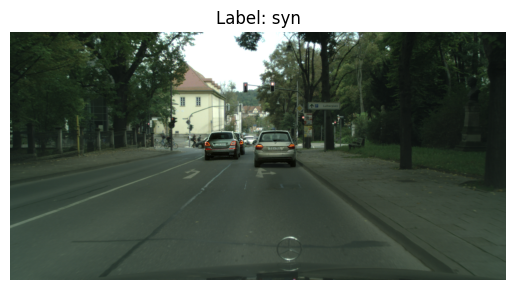

합성 데이터입니다.
첫 번째 이미지 경로: /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit/train/jena/jena_000055_000019_leftImg8bit.png
레이블: syn


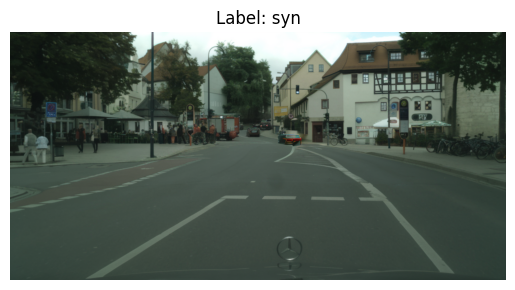

합성 데이터입니다.
첫 번째 이미지 경로: /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/synthetic/leftImg8bit/train/jena/jena_000114_000019_leftImg8bit.png
레이블: syn


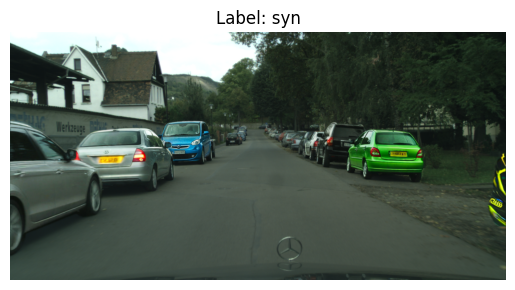

In [ ]:
# check_syn_data(replaced_paths, 3)
check_syn_data(replaced_paths_overlap, 3)

In [ ]:
# dataloader_test(train_loader)

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-10-f228e6f3f4b8>", line 16, in __getitem__
    gtFine_path = self.gtFine_paths[idx]
                  ~~~~~~~~~~~~~~~~~^^^^^
IndexError: string index out of range


In [ ]:
# for images, targets, labels in train_loader:
#     targets[targets == 0] = 255  # 클래스 0은 무시
#     targets[targets > num_classes] = 255  # 19 이상(예: 23)은 무시 (ignore_index=255)
#     targets=targets-1
#     print(torch.unique(targets))
#     print(f"Images Shape: {images.shape}")  # (batch_size, C, H, W)
#     print(f"Targets Shape: {targets.shape}")  # (batch_size, H, W)

#     break

val_loader 생성

In [ ]:
val_dataset = Cityscapes(
    real_root,
    split='val',  # 테스트 데이터 사용
    mode='fine',
    target_type='semantic',  # 레이블 있음
    transform=transform,
    target_transform=target_transform
)

val_loader = DataLoader(val_dataset, batch_size, shuffle=False, num_workers=8)

pretrained model 가져옴

In [ ]:
# 난 분명 GPU가 있는데 없다고 할 때
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torch.optim import AdamW

model = models.deeplabv3_resnet101(weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)  # Cityscapes has 19 classes
model = model.to(device)

# # classifier에 Dropout 추가
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.5),  # Dropout 추가
#     model.classifier[0],  # 기존 Convolution Layer 유지
#     model.classifier[1]   # 기존 BatchNorm 및 Activation 유지
# )

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr)
optimizer = torch.optim.AdamW(model.parameters(), lr)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 201MB/s]


In [ ]:
# from transformers import SegformerForSemanticSegmentation
# from torch.optim import AdamW

# # Initialize SegFormer model
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b2")
# # model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0")  # You can choose different variants like mit-b1, mit-b2, etc.
# model.to(device)


# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [ ]:
print(type(model).__name__)

DeepLabV3


모델 학습

In [1]:
import wandb

# wandb 초기화 및 APㄹI 키 입력
# wandb_api_key = input("Enter your wandb API key: ")
wandb.finish()

wandb_api_key = ''
wandb.login(key=wandb_api_key)
wandb.init(project="AimmoSyntheticTest", config={
    "epochs": epoch,
    "batch_size": batch_size,
    "learning_rate": lr,
    "num_classes": num_classes
}, settings=wandb.Settings(console="wrap", init_timeout=600))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


NameError: name 'epoch' is not defined

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# # 저장된 체크포인트 불러오기
# checkpoint = torch.load('/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/checkpoint_dice_25.02.17_DeepLabV3_0.0_16_0.001_20_0.3742_0.4733.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Optimizer 상태 불러오기
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])  # Scheduler 상태 불러오기
# epoch = checkpoint['epoch']

In [ ]:
# # 손실 함수 수정 (255 무시)
# criterion = nn.CrossEntropyLoss(ignore_index=255)

# 하이퍼파라미터 설정
epochs = 26
patience = 10  # Early Stopping patience
min_delta = 0.01  # Early Stopping min_delta

# 학습 루프 실행
train_loop(epochs, patience=patience, min_delta=min_delta)

# wandb 종료
wandb.finish()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Validation: 100%|██████████| 32/32 [00:14<00:00,  2.24batch/s, loss=0.587]


Early stopping triggered at epoch 26
모델 저장 완료: /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/model/EarlyStopAndScheduler/best_model_dice+cross+back_25.02.20_DeepLabV3_1.0_16_0.001_26_0.3722_0.4954.pth


batch,▁▇█▁▃▁▄▅▃▂▆▂▃█▄▇█▂▃█▅▅▅▂▂▁█▄▇▅▅▃▁▂▃▁▄▂▁▆
ce_loss,█▇▆▆█▄▃▃▄▃▃▃▃▂▃▃▃▃▂▁▁▂▂▂▂▁▂▁▁▁▁▁▁▃▂▁▂▁▁▁
dice_loss,██▅▅▅▅▄▅▄▄▅▄▅▃▄▃▄▄▃▃▄▃▃▃▄▂▁▂▁▂▁▃▂▂▂▂▂▂▂▂
epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇████
epoch_train_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁
epoch_val_loss,▃▃▂▄▂█▅▂▂▄▂▂▄▁▂▃▁▂▂▁▁▃▃▁▁▁
train_loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▂▂▁▁▁▁
val_ce_loss,▃▄▃▂▂▇█▁▂▄▂▂▃▅▂▁▂▂▂▄▃▃▃▂▃▁▁▂▂▂▃▂▁▄▄▁▁▃▂▁
val_dice_loss,▅▅▅▅▄▅▄▄█▄▂▄▄▅▇▃▃▁▅▆▃▃▂▂▃▁▁▁▂▁▂▂▂▆▃▃▂▂▂▂
val_loss,▆▆▅▄▃▄▃▄█▅▇▇▄▇▆▆▇▇▄▂▄▂▅▁▄▂▃▂▃▁▅▇▄▃▇▁▃▄▂▃
batch,31


In [ ]:
# # tqdm이 2줄 내려가고 1줄씩 출력될 때
# while len(tqdm._instances) > 0:
#     tqdm._instances.pop().close()

### COCO

---
#### CityScrapeJsonToCoco

In [ ]:
!git clone https://github.com/TillBeemelmanns/cityscapes-to-coco-conversion

In [ ]:
# cd /content/cityscapes-to-coco-conversion

In [ ]:
# !pip install -r requirements.txt
# !python main.py --dataset cityscapes --datadir="/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data" --outdir="/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/annotations"

In [ ]:
!python inspect_coco.py --coco_dir /content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data

In [ ]:
import json

path = "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/real/data/annotations/instancesonly_filtered_gtFine_train.json"

with open(path, "r") as f:
    data = json.load(f)

categories = data["categories"]  # 클래스 정보 확인
for cat in categories:
    print(cat["id"], cat["name"])

In [ ]:
import torch
import torchvision
import json
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm

# Hyperparameters
CONFIG = {
    "batch_size": 4,
    "num_epochs": 5,
    "learning_rate": 1e-4,
    "pretrained_model": "fasterrcnn_resnet50_fpn",
    "dataset_path": "/content/drive/MyDrive/Aimmo/Dataset/20250203_CityScapes_Dataset/",
    "syn_ratio": 0.5,  # 원본 vs 합성 데이터 비율 (0, 0.25, 0.5, 0.75, 1.0)
    "save_best_model": "best_model.pth",
}

In [ ]:
# COCO Dataset Customization
class CustomCocoDataset(Dataset):
    def __init__(self, annotation_file, image_dir, transform=None, scale_factor=0.5):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.transform = transform
        self.scale_factor = scale_factor
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Load image
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")

        # 합성 이미지 annotation 설정 원본은 1.0, 합성은 0.5가 곱해짐
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann['bbox']
            x, y, w, h = x * self.scale_factor, y * self.scale_factor, w * self.scale_factor, h * self.scale_factor
            seg = ann['segmentation']
            seg = [[int(coord * self.scale_factor) for coord in polygon] for polygon in seg]
            ann['segmentation'] = seg
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
# 데이터셋 불러오기
def get_dataloaders():
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    real_dataset = CustomCocoDataset(
        annotation_file=os.path.join(CONFIG["dataset_path"], "real/data/annotations/instancesonly_filtered_gtFine_train.json"),
        image_dir=os.path.join(CONFIG["dataset_path"], "real/data/"),
        transform=transform,
        scale_factor=1.0
    )

    synthetic_dataset = CustomCocoDataset(
        annotation_file=os.path.join(CONFIG["dataset_path"], "real/data/annotations/instancesonly_filtered_gtFine_train.json"),
        image_dir=os.path.join(CONFIG["dataset_path"], "synthetic/data/"),
        transform=transform,
        scale_factor=0.5  # 합성 데이터는 원본보다 절반 크기
    )

    real_size = int(len(real_dataset) * CONFIG["syn_ratio"])
    synthetic_size = len(real_dataset) - real_size

    dataset = torch.utils.data.ConcatDataset([
        torch.utils.data.Subset(real_dataset, range(real_size)),
        torch.utils.data.Subset(synthetic_dataset, range(synthetic_size))
    ])

    dataloader = DataLoader(dataset, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    return dataloader

# Pretrained Model 가져오기
def get_model():
    model_func = getattr(torchvision.models.detection, CONFIG["pretrained_model"], None)
    if model_func is None:
        raise ValueError(f"Invalid model name: {CONFIG['pretrained_model']}")
    model = model_func(pretrained=True)
    model.train()
    return model

# 학습 함수
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataloader = get_dataloaders()
    model = get_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["learning_rate"])
    best_loss = float("inf")

    for epoch in range(CONFIG["num_epochs"]):
        epoch_loss = 0.0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']}")

        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), CONFIG["save_best_model"])
            print(f"Best model saved with loss {best_loss:.4f}")

    print("Training Finish")

In [ ]:
train()